## HW Part 1

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
##定義使用的Augmentation
img_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=10,
                             width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                             horizontal_flip=True, vertical_flip=False, dtype=np.float32)
width=224
height=224
batch_size=4

In [3]:
img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224)) ##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)
img_combine=np.array([img,img,img,img],dtype=np.uint8) ##輸入generator要是四維，(224,224,3)變成(4,224,224,3)
batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape==(batch_size, width, height, 3)

C:\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


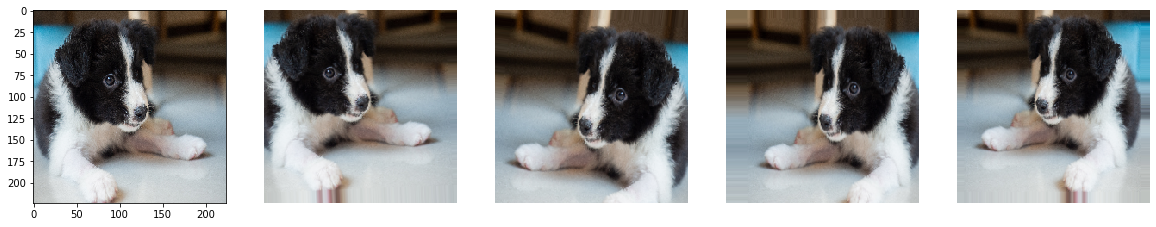

In [4]:
plt.figure(figsize=(20,10))
i = 1
for batch in batch_gen:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin) ##原圖
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.imshow(batch[1, :, :, :].astype(np.uint8))
    plt.imshow(batch[2, :, :, :].astype(np.uint8))
    plt.imshow(batch[3, :, :, :].astype(np.uint8))
    plt.axis('off')
    i += 1
    if i > 4:
        break  # or the generator would loop infinitely

In [5]:
# 以下示範導入 Image Data Generator 到訓練中
#Training Generator
train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
#Test Generator，只需要Rescale，不需要其他增強
test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
#將路徑給Generator，自動產生Label
training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 21000 images belonging to 2 classes.


In [23]:
test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4000 images belonging to 2 classes.


In [16]:
# Modeling
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

classifier=Sequential()
classifier.add(Convolution2D(filters=32, kernel_size=(3,3) , input_shape=(64,64,3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Convolution2D(filters=32, kernel_size=(3,3) , input_shape=(32,32,3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Flatten())
classifier.add(Dense(100, activation='relu'))
classifier.add(Dense(output_dim=2,activation='softmax'))
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=2)`


In [17]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
#訓練
classifier.fit_generator(training_set, steps_per_epoch = None, nb_epoch = 1,
                         validation_data = None, validation_steps = None)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=None, validation_data=None, validation_steps=None, epochs=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/1
657/657 [==============================] - 201s 307ms/step - loss: 0.8258 - accuracy: 0.6743


In [26]:
#預測新照片
from keras.preprocessing import image as image_utils
test_image = image_utils.load_img('dataset/new_images/1.jpg', target_size=(64, 64))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) 

result = classifier.predict_on_batch(test_image)
print(result)

[[0.5531487 0.4468513]]


## 練習使用Imgaug，使用單項增強

In [30]:
# 必須先裝這個：pip install Shapely-1.6.4.post2-cp37-cp37m-win_amd64.whl
# 再裝這個：pip install imgaug
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)

images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8)##創造一個array size==(5, 224, 224, 3)

flipper = iaa.Fliplr(1.0) #水平翻轉機率==1.0
images[0] = flipper.augment_image(img) 

vflipper = iaa.Flipud(0.4) #垂直翻轉機率40%
images[1] = vflipper.augment_image(img) 

blurer = iaa.GaussianBlur(3.0)
images[2] = blurer.augment_image(img) # 高斯模糊圖像( sigma of 3.0)

translater = iaa.Affine(translate_px={"x": -16}) #向左橫移16個像素
images[3] = translater.augment_image(img) 

scaler = iaa.Affine(scale={"y":0.8}) # 縮放照片，區間(0.8-1.2倍)
images[4] = scaler.augment_image(img)

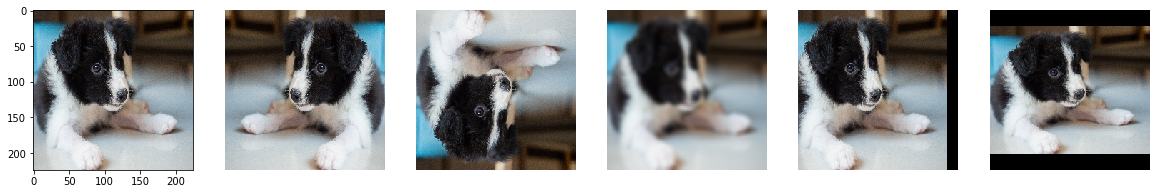

In [32]:
i=1
plt.figure(figsize=(20,20))
plt.subplot(1, 6, 1) # 畫原圖
plt.imshow(img_origin.astype(np.uint8))
for image in images:
    plt.subplot(1, 6, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

## Part 2

In [49]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

##輸入照片
img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)

img_combine=np.array([img,img,img,img], dtype=np.uint8) # np.float32) 這裡很重要******* 

sometimes = lambda aug: iaa.Sometimes(0.5, aug) # Sometimes(0.5, ...) 代表每次都有50%的機率運用不同的Augmentation

##包裝想運用之圖像強化方式
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.4), 
   sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
        rotate=(-10, 10),
        shear=(-8, 8), 
        order=[0, 1], 
        cval=(0, 255),
        mode=ia.ALL 
    )),
    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
    sometimes(iaa.OneOf([
    iaa.GaussianBlur((0, 3.0)), # blur images 
                    iaa.AverageBlur(k=(1,3)), # blur image using local means with kernel sizes between 1 and 3
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                ])),
     sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
     sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
    ],random_order=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


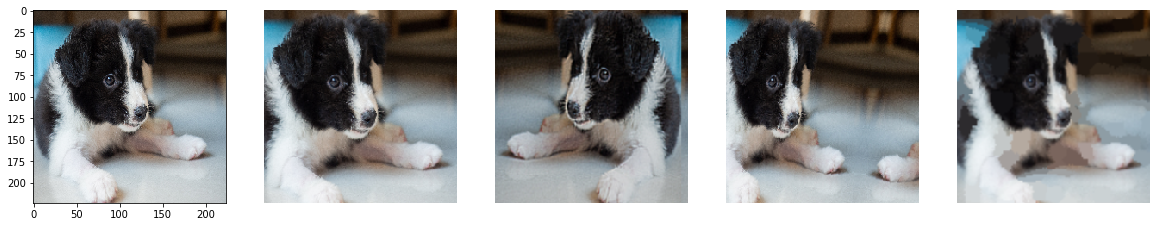

In [51]:
images_aug = seq.augment_images(img_combine) ## Image Augmentation

##畫出來
i=1
plt.figure(figsize=(20,20))
for image in images_aug:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin.astype(np.uint8))
    plt.subplot(1, 5, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

## 包裝自定義Augmentation 與 Imgaug Augmentation

In [52]:
from PIL import Image
import os
import pickle
import numpy as np
import cv2
import glob
import pandas as pd
import time
import random
import imgaug as ia
import imgaug.augmenters as iaa

'''隨機改變亮度'''    
class RandomBrightness(object):
    '''Function to randomly make image brighter or darker
    Parameters
    ----------
    delta: float
        the bound of random.uniform distribution
    '''
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''隨機改變對比'''
class RandomContrast(object):
    '''Function to strengthen or weaken the contrast in each image
    Parameters
    ----------
    lower: float
        lower bound of random.uniform distribution
    upper: float
        upper bound of random.uniform distribution
    '''
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower."
        assert lower >= 0, "contrast lower must be non-negative."
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''包裝所有Augmentation'''
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image= t(image)
        return image

'''包裝Imgaug'''
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = self.sequence.augment_image(image)
      
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        #Define imgaug.augmenters Sequential transforms
        sometimes = lambda aug: iaa.Sometimes(0.4, aug) # applies the given augmenter in 50% of all cases

        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1),),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
            ],random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16), #make image brighter or darker
            RandomContrast(0.9, 1.1), #strengthen or weaken the contrast in each image
            ImgAugSequence(img_seq),
        ])
        

    def __call__(self, image):
        image= self.aug_pipeline(image)
        return image
    
Augmenation=TrainAugmentations()

C:\Anaconda3\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


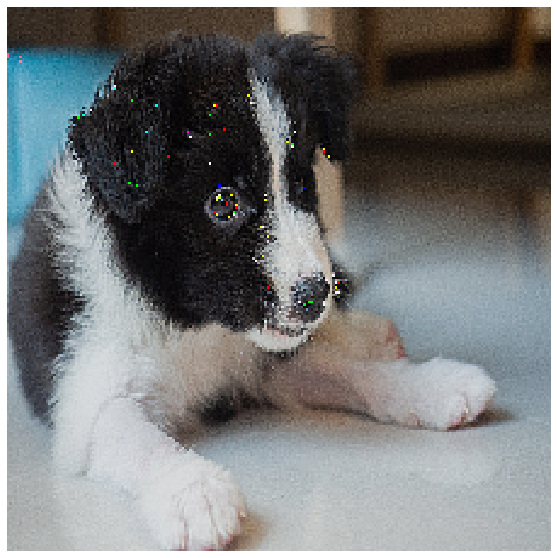

In [54]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

##輸入照片
img = cv2.imread('data/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB

output=Augmenation(img) 

##畫出來
plt.figure(figsize=(10,10))
for image in images_aug:
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')

## 鎖住隨機性-主要用在Semantic segmentation中

In [55]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask